In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import skimage.measure as measure
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import cv2
from skimage import exposure

import copy

from tqdm import tqdm

# import sklearn as sk
import tensorflow as tf
from pathlib import Path

In [2]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow import keras

In [3]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!nvidia-smi

Fri May  6 16:37:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    38W / 350W |   1993MiB / 12288MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# read in all our data
COVID19_data = pd.read_csv("../COVID_19_DATA_FEATURES.csv")
# read in all our data
COVID19_data_template = pd.read_csv("../COVID_19_DATA_FEATURES_TEMPLATE.csv")

COVID19_image_NY_db = pd.read_csv("../COVID-19-CHEST-ONLY/manifest-1645033969298/metadata.csv")

In [7]:
# C19_d = pd.DataFrame(COVID19_data[['to_patient_id','is_icu']])
C19_d = COVID19_data

In [8]:
NEW_PATH_DB = copy.deepcopy(COVID19_image_NY_db)

In [9]:
for path in COVID19_image_NY_db['File Location']:
    pt = Path(path)
    # if (int(pt.stem) % 2 == 0):
    if (int(pt.stem) != 1):
        NEW_PATH_DB = NEW_PATH_DB[NEW_PATH_DB['File Location'] != path]

In [10]:
dataFolder = Path("../COVID-19-CHEST-ONLY/manifest-1645033969298/")

In [11]:
#PROGNOSIS: deceased = 1, discharged = 0
prognosis = {True: 'SEVERE', False: 'MILD'}
C19_d = C19_d.replace({'is_icu': prognosis})

In [12]:
from pydicom import dcmread, read_file
from pydicom.pixel_data_handlers.util import apply_voi_lut

# file = COVID19_data['file Path'][0] / '1-1.dcm'

# ds = dcmread(file)
# npArrayFile = ds.pixel_array 

In [13]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    # data = data.reshape(data.shape[0], data.shape[1], 1)
    
    return data

In [14]:
# def save2png(dbIM,dbLab,pathIn,pathOut):
#     pathMild = pathOut + '/MILD'
#     pathSevere = pathOut + '/SEVERE'
#     Path(pathMild).mkdir(parents=True, exist_ok=True)
#     Path(pathSevere).mkdir(parents=True, exist_ok=True)
#     i = 0
#     for pt,ph in tqdm(zip(dbIM['File Location'],dbIM['Data Description URI']),total=len(dbIM['File Location'])):
#         # print(ph)
#         label = dbLab[dbLab['to_patient_id']==ph]['is_icu'].values[0]
#         # print(label)
#         path = pathIn / pt
#         # print(path)
#         path = path / '1-1.dcm'
#         # print(path)
#         img = read_xray(path)
#         # print(img.shape)
#         img = Image.fromarray(img)
#         nameOfFile = str(i)+'_'+ph+'.png'
#         # print(nameOfFile)
#         i = i+1
#         if (label == 'SEVERE'):
#             img.save(pathSevere+'/'+nameOfFile)
#         else:
#             img.save(pathMild+'/'+nameOfFile)


In [15]:
def save2png(dbIM,dbLab,pathIn,pathOut):
    newDB = copy.deepcopy(dbLab)
    print(newDB.shape)
    pathMild = pathOut + '/MILD'
    pathSevere = pathOut + '/SEVERE'
    Path(pathMild).mkdir(parents=True, exist_ok=True)
    Path(pathSevere).mkdir(parents=True, exist_ok=True)
    i = 0

    newPaths = []

    for patientName in tqdm(dbLab['to_patient_id']):
    # for patientName in dbLab['to_patient_id']:

        # print(patientName)
        label = dbLab[dbLab['to_patient_id']==patientName]['is_icu'].values[0]  #value equal for all images

        paths = dbIM[dbIM['Data Description URI']==patientName]['File Location']
        dates = dbIM[dbIM['Data Description URI']==patientName]['Study Description']

        dates = pd.to_datetime(dates)


        paths.reset_index(inplace=True, drop=True)
        dates.reset_index(inplace=True, drop=True)

        # print(paths)
        # print(dates)
        dates = dates.sort_values()

        paths = paths[dates.index]
        # print(paths.index)
        # print(dates)
        # print(paths)

        paths.reset_index(inplace=True, drop=True)
        dates.reset_index(inplace=True, drop=True)
        
        # print(dates)
        # print(paths)


        # paths = dbIM[dbIM['Data Description URI']==patientName]['File Location']
        if len(paths)==0:
            # print(patientName)
            #drop any rows that have 7 in the rebounds column
            newDB = newDB[newDB.to_patient_id != patientName]

        else:


            uniques, indices, inv, counts = np.unique(dates, return_index=True, return_counts=True,return_inverse = True)
            # print(uniques)
            # print(indices)
            uniquesPaths= paths[indices]
            # print(uniquesPaths)

            #take only oldest:

            path = uniquesPaths[0]
            path = pathIn / path
            path = path / '1-1.dcm'
            img = read_xray(path)
            img = Image.fromarray(img)
            nameOfFile = str(i)+'_'+patientName+'.png'
            i = i+1
            if (label == 'SEVERE'):
                img.save(pathSevere+'/'+nameOfFile)
                newPaths.append('/SEVERE'+'/'+nameOfFile)
            else:
                img.save(pathMild+'/'+nameOfFile)
                newPaths.append('/MILD'+'/'+nameOfFile)
                
            # break

            # all images:

            # numImg = 0

            # for pt in uniquesPaths:
                
                
                
            #     # break

            #     path = pt
            #     path = pathIn / path
            #     path = path / '1-1.dcm'
            #     img = read_xray(path)
            #     img = Image.fromarray(img)
            #     nameOfFile = str(i)+'_'+patientName+'_'+str(numImg)+'.png'
            #     i = i+1
            #     if (label == 'SEVERE'):
            #         img.save(pathSevere+'/'+nameOfFile)
            #         newPaths.append('/SEVERE'+'/'+nameOfFile)
            #     else:
            #         img.save(pathMild+'/'+nameOfFile)
            #         newPaths.append('/MILD'+'/'+nameOfFile)

            #     numImg = numImg + 1


        # if (len(paths)==0 or dbIM[dbIM['Data Description URI']==patientName]['Study Date'].values[0] == 'PA'):
        #     # print(patientName)
        #     #drop any rows that have 7 in the rebounds column
        #     newDB = newDB[newDB.to_patient_id != patientName]
        # else:

        #     path = paths.values[0]
        #     path = pathIn / path
        #     path = path / '1-1.dcm'
        #     img = read_xray(path)
        #     img = Image.fromarray(img)
        #     nameOfFile = str(i)+'_'+patientName+'.png'
        #     i = i+1
        #     if (label == 'SEVERE'):
        #         img.save(pathSevere+'/'+nameOfFile)
        #         newPaths.append('/SEVERE'+'/'+nameOfFile)
        #     else:
        #         img.save(pathMild+'/'+nameOfFile)
        #         newPaths.append('/MILD'+'/'+nameOfFile)

    
    #take only oldest:
    
    newDB['FilePaths'] = newPaths
    print(newDB.shape)
    newDB.to_csv(pathOut + '/newDB.csv')


In [16]:
# save2png(NEW_PATH_DB,C19_d,dataFolder,'../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST')

In [17]:
# save2png(COVID19_image_NY_db,C19_d,dataFolder,'../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-ALL-ORDERED')

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize

In [19]:
# HackDB = pd.read_excel("HACKATON-COVID19/trainClinData.xls")

In [20]:
# dataFolder = Path('HACKATON-COVID19/TrainSet/')

In [21]:
import math

In [22]:
import keras_ocr

kerasOcr_pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\Michele\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Michele\.keras-ocr\crnn_kurapan.h5


In [23]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

In [24]:
# def deleteWritings(imgPath,pipeline):
    
#     img = keras_ocr.tools.read(imgPath)
#     prediction_groups = pipeline.recognize([img])
    
#     mask = np.zeros(img.shape[:2], dtype="uint8")

#     for box in prediction_groups[0]:
#         x0, y0 = box[1][0]
#         x1, y1 = box[1][1] 
#         x2, y2 = box[1][2]
#         x3, y3 = box[1][3] 
        
#         x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
#         x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
#         thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
#         cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
#         thickness)
#         img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

#     return img

In [25]:
def deleteWritings(imgPath,pipeline):
    
    img = keras_ocr.tools.read(imgPath)
    prediction_groups = pipeline.recognize([img])
    
    mask = np.zeros(img.shape[:2], dtype="uint8")

    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
    return img

In [26]:
def invert_if_negative(img,quad = 200):
    # print(img.shape)
    # assuming image has fixed size of (1396, 1676)
    # corners
    top_left  = img[:quad, :quad].flatten()
    topRPoint = img.shape[1]-quad
    # print(topRPoint)
    top_right = img[:quad, topRPoint:].flatten()
    # more or less center

    cLpU = math.floor(img.shape[0]/2) - quad
    cRpU = math.floor(img.shape[0]/2) + quad
    cLpD = math.floor(img.shape[1]/2) - quad
    cRpD = math.floor(img.shape[1]/2) + quad
    # print(cLpU)
    # print(cRpU)
    # print(cLpD)
    # print(cRpD)
    center    = img[cLpU:cRpU, cLpD:cRpD].flatten()
    threshold = 127 # or computed from average
    top_left  = top_left > threshold
    top_right = top_right > threshold
    center    = center > threshold
    perc_white_corners = (sum(top_left) + sum(top_right)) / (len(top_left) + len(top_right))
    perc_white_center = sum(center) / len(center)
    if perc_white_corners > perc_white_center:
        img = 255 - img
    return img

In [27]:
# Imports:
import cv2

# Image path
def cv2ImEqualization(originalGrayscale,eq):
    # Reading an image in default mode:
    # originalGrayscale = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # print(data_directory + '/P_1_7.png')
    # cv2.imshow("Image Equalized", inputImage)
    # cv2.waitKey(0)

    # Convert RGB to grayscale:
    # originalGrayscale = cv2.cvtColor(originalGrayscale, cv2.COLOR_BGR2GRAY)

    # Equalize histogram
    # grayscaleImage = cv2.equalizeHist(originalGrayscale)


    # grayscaleImage = originalGrayscale
    
    
    grayscaleImage = eq.apply(originalGrayscale)


    # It might be interesting to you to check out the image equalization:
    # cv2.imshow("Image Equalized", grayscaleImage)
    # cv2.waitKey(0)
    
    grayscaleImage = invert_if_negative(grayscaleImage,200)

    
    return grayscaleImage

In [28]:
def saveFolderHackaton(dbIM,pathIn,pathOut):

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))

    pathMild = pathOut + '/MILD'
    pathSevere = pathOut + '/SEVERE'
    Path(pathMild).mkdir(parents=True, exist_ok=True)
    Path(pathSevere).mkdir(parents=True, exist_ok=True)
    for pt,lb in tqdm(zip(dbIM['ImageFile'],dbIM['Prognosis']),total=len(dbIM['ImageFile'])):
        fileName = pt
        pt = pathIn / pt
        # print(pt)
        img = img_to_array(load_img(pt,color_mode='grayscale'),dtype='float32')
        img = np.amax(img) - img 
        img = img - np.min(img)
        img = img / np.max(img)
        img = (img * 255).astype(np.uint8)
        img = cv2ImEqualization(img,clahe)
        if (lb == 'SEVERE'):
            cv2.imwrite(pathSevere+'/'+fileName,img)
        else:
            cv2.imwrite(pathMild+'/'+fileName,img)

In [29]:
# def saveFolderHackaton(dbIM,pathIn,pathOut):
#     pathMild = pathOut + '/MILD'
#     pathSevere = pathOut + '/SEVERE'
#     Path(pathMild).mkdir(parents=True, exist_ok=True)
#     Path(pathSevere).mkdir(parents=True, exist_ok=True)
#     for pt,lb in tqdm(zip(dbIM['ImageFile'],dbIM['Prognosis']),total=len(dbIM['ImageFile'])):
#         fileName = pt
#         pt = pathIn / pt
#         # print(path)
#         img = img_to_array(load_img(pt,color_mode='grayscale'),dtype='float32')
#         img = np.amax(img) - img 
#         img = img - np.min(img)
#         img = img / np.max(img)
#         img = (img * 255).astype(np.uint8)
#         img = np.squeeze(img, axis=2)  # axis=2 is channel dimension 
#         # print(img[1000,:,0])
#         img = Image.fromarray(img)
#         # print(nameOfFile)
#         if (lb == 'SEVERE'):
#             img.save(pathSevere+'/'+fileName)
#         else:
#             img.save(pathMild+'/'+fileName)

In [30]:
# dataFolder = Path('LAST-DIVISION-COVID-h/TRAIN/MILD')

In [31]:
# saveFolderHackaton(HackDB,dataFolder,'LAST-DIVISION-COVID-h-EQ/TRAIN')

In [32]:
# # function used to reverse the color of an RX image (check the center of the image and invert if the majority is white) - not always reliable
# def invert_if_negative(img,quad = 200):
#     # print(img.shape)
#     # assuming image has fixed size of (1396, 1676)
#     # corners
#     top_left  = img[:quad, :quad].flatten()
#     topRPoint = img.shape[1]-quad
#     # print(topRPoint)
#     top_right = img[:quad, topRPoint:].flatten()
#     # more or less center

#     cLpU = math.floor(img.shape[0]/2) - quad
#     cRpU = math.floor(img.shape[0]/2) + quad
#     cLpD = math.floor(img.shape[1]/2) - quad
#     cRpD = math.floor(img.shape[1]/2) + quad
#     # print(cLpU)
#     # print(cRpU)
#     # print(cLpD)
#     # print(cRpD)
#     center    = img[cLpU:cRpU, cLpD:cRpD].flatten()
#     threshold = 127 # or computed from average
#     top_left  = top_left > threshold
#     top_right = top_right > threshold
#     center    = center > threshold
#     perc_white_corners = (sum(top_left) + sum(top_right)) / (len(top_left) + len(top_right))
#     perc_white_center = sum(center) / len(center)
#     if perc_white_corners > perc_white_center:
#         img = 255 - img
#     return img


# equalize images and save the equalized one:

# need:
# cv2
# Path
# numpy
# tqdm (facoltativo se in for viene tolto tqdm)
# load_img and img_to_array from tensorflow.keras.preprocessing.image

def equalizeImages(pathIn,pathOut):     #pathIn = path of all images to be equalized        pathOut = path where to save equalized images
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))        # equalizer from cv2 CLAHE(Contrast Limited Adaptive Histogram Equalization) - https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

    Path(pathOut).mkdir(parents=True, exist_ok=True)        #create folder for path out

    for pt in tqdm(os.listdir(pathIn)):         # for all paths (of images) in pathIn directory
        fileName = pt               #name of the image
        pt = pathIn / pt            #dir path + name of the image
        # print(pt)

        img = img_to_array(load_img(pt,color_mode='grayscale'),dtype='float32')     #load as numpy array with keras image utilities (can use cv2 to load image)

        # normalize image
        img = np.amax(img) - img 
        img = img - np.min(img)
        img = img / np.max(img)
        
        # transform to image for equalization
        img = (img * 255).astype(np.uint8)

        # equalization using clahe equalizer from cv2
        img = clahe.apply(img)
        # img = invert_if_negative(img,200)           # other function used for invert the RX images where bones are black
        
        # img = cv2ImEqualization(img,clahe)        # other function used for invert the RX images where bones are black
        
        cv2.imwrite(pathOut+'/'+fileName,img)       # save the equalized image to the output path folder

In [33]:
# # function used to reverse the color of an RX image (check the center of the image and invert if the majority is white) - not always reliable
# def invert_if_negative(img,quad = 200):
#     # print(img.shape)
#     # assuming image has fixed size of (1396, 1676)
#     # corners
#     top_left  = img[:quad, :quad].flatten()
#     topRPoint = img.shape[1]-quad
#     # print(topRPoint)
#     top_right = img[:quad, topRPoint:].flatten()
#     # more or less center

#     cLpU = math.floor(img.shape[0]/2) - quad
#     cRpU = math.floor(img.shape[0]/2) + quad
#     cLpD = math.floor(img.shape[1]/2) - quad
#     cRpD = math.floor(img.shape[1]/2) + quad
#     # print(cLpU)
#     # print(cRpU)
#     # print(cLpD)
#     # print(cRpD)
#     center    = img[cLpU:cRpU, cLpD:cRpD].flatten()
#     threshold = 127 # or computed from average
#     top_left  = top_left > threshold
#     top_right = top_right > threshold
#     center    = center > threshold
#     perc_white_corners = (sum(top_left) + sum(top_right)) / (len(top_left) + len(top_right))
#     perc_white_center = sum(center) / len(center)
#     if perc_white_corners > perc_white_center:
#         img = 255 - img
#     return img


# equalize images and save the equalized one:

# need:
# cv2
# Path
# numpy
# tqdm (facoltativo se in for viene tolto tqdm)
# load_img and img_to_array from tensorflow.keras.preprocessing.image

def equalizeImages(pathIn,pathOut):     #pathIn = path of all images to be equalized        pathOut = path where to save equalized images
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))        # equalizer from cv2 CLAHE(Contrast Limited Adaptive Histogram Equalization) - https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

    Path(pathOut).mkdir(parents=True, exist_ok=True)        #create folder for path out

    for pt in tqdm(os.listdir(pathIn)):         # for all paths (of images) in pathIn directory
        fileName = pt               #name of the image
        pt = pathIn / pt            #dir path + name of the image
        # print(pt)

        img = img_to_array(load_img(pt,color_mode='grayscale'),dtype='float32')     #load as numpy array with keras image utilities (can use cv2 to load image)

        # normalize image
        img = np.amax(img) - img 
        img = img - np.min(img)
        img = img / np.max(img)
        
        # transform to image for equalization
        img = (img * 255).astype(np.uint8)

        # equalization using clahe equalizer from cv2
        img = clahe.apply(img)
        # img = invert_if_negative(img,200)           # other function used for invert the RX images where bones are black
        
        cv2.imwrite(pathOut+'/'+fileName,img)       # save the equalized image to the output path folder

In [34]:
# outputPath = Path('../FirstImageInTimeNYPNG')

In [35]:
# dataFolder = Path('LAST-DIVISION-COVID-h/TRAIN/MILD')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/TRAIN/MILD')
# dataFolder = Path('LAST-DIVISION-COVID-h/TRAIN/SEVERE')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/TRAIN/SEVERE')
# dataFolder = Path('LAST-DIVISION-COVID-h/VAL/MILD')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/VAL/MILD')
# dataFolder = Path('LAST-DIVISION-COVID-h/VAL/SEVERE')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/VAL/SEVERE')
# dataFolder = Path('LAST-DIVISION-COVID-h/TEST/MILD')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/TEST/MILD')
# dataFolder = Path('LAST-DIVISION-COVID-h/TEST/SEVERE')
# equalizeImages(dataFolder,'LAST-DIVISION-COVID-h-EQ/TEST/SEVERE')

In [36]:
import os

In [37]:
def dText(pathIn,pathOut):
    Path(pathOut).mkdir(parents=True, exist_ok=True)
    for filename in tqdm(os.listdir(pathIn)):
        f = pathIn / filename
        fo = pathOut / filename


        img = deleteWritings(str(f),kerasOcr_pipeline)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(str(fo),img)

In [ ]:
imgColorPath = []
imgDepthPath = []

for pathFile in os.listdir('HR'):
    if cartellaPadreDiPathfile == 'color':              # trovare il modo di prendere solo i path dei file che sono all'interno delle cartelle color
        imgColorPath.append(pathFile)
    if cartellaPadreDiPathfile == 'depth_vi':           # trovare il modo di prendere solo i path dei file che sono all'interno delle cartelle depth_vi
        imgDepthPath.append(pathFile)


print(imgColorPath)     #ritorna la lista di tutti i path di immagini color


imgColorPath = imgColorPath.sort()
imgDepthPath = imgDepthPath.sort()


X_tr,Y_tr,X_vl,Y_vl = train_test_split(imgColorPath,imgDepthPath, test_size=0.2,shuffle=True)


X_trIMG = loadPNGtoArray(X_tr)
Y_trIMG = loadPNGtoArray(Y_tr)
X_vlIMG = loadPNGtoArray(X_vl)
Y_vlIMG = loadPNGtoArray(Y_vl)



In [38]:
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/TRAIN/MILD')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/TRAIN/MILD')
# dText(pathIn,pathOut)
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/TRAIN/SEVERE')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/TRAIN/SEVERE')
# dText(pathIn,pathOut)
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/VAL/MILD')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/VAL/MILD')
# dText(pathIn,pathOut)
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/VAL/SEVERE')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/VAL/SEVERE')
# dText(pathIn,pathOut)
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/TEST/MILD')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/TEST/MILD')
# dText(pathIn,pathOut)
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/TEST/SEVERE')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/TEST/SEVERE')
# dText(pathIn,pathOut)

In [39]:
# def EqAndSave(img,pathOut,fileName):
#     img = np.amax(img) - img 
#     img = img - np.min(img)
#     img = img / np.max(img)
#     img = (img * 255).astype(np.uint8)
#     img = cv2ImEqualization(img)
#     cv2.imwrite(fileName,img)


In [40]:
# import os
# for filename in tqdm(os.listdir(pathIn)):
#     f = pathIn / filename
#     fo = pathOut / filename
#     img = deleteWritings(str(f),kerasOcr_pipeline)

#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(str(fo),img)


In [41]:
# pathIn = Path('LAST-DIVISION-COVID-h-EQ/TRAIN/SEVERE')
# pathOut = Path('LAST-DIVISION-COVID-h-NO-TEXT/TRAIN/SEVERE')

In [42]:
# import os
# for filename in tqdm(os.listdir(pathIn)):
#     f = pathIn / filename
#     fo = pathOut / filename
#     img = deleteWritings(str(f),kerasOcr_pipeline)

#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(str(fo),img)

In [43]:


# # mild:

# pathIn = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/WITH TEXT/MILD')
# pathOut = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/MILD')

# dText(pathIn,pathOut)
# pathOutEQ = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/MILD')
# equalizeImages(pathOut,str(pathOutEQ))

# # severe:

# pathIn = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/WITH TEXT/SEVERE')
# pathOut = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/SEVERE')

# dText(pathIn,pathOut)
# pathOutEQ = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/SEVERE')
# equalizeImages(pathOut,str(pathOutEQ))

In [44]:
# # TESTSET:

# dataFolder = Path('FINAL-TESTSET/TestSet')
# equalizeImages(dataFolder,'FINAL-TESTSET/TESTSET-EQ')

# pathIn = Path('FINAL-TESTSET/TESTSET-EQ')
# pathOut = Path('FINAL-TESTSET/TESTSET-EQ-NO-TEXT')
# dText(pathIn,pathOut)

In [45]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [46]:
# modello per segmentazione:
segmentationModel = load_model('../TOOLS/trained_model.hdf5')

In [47]:
segmentationModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_1[0][0]']               
                                )                                                           

In [48]:
inputImages = image_dataset_from_directory(
    '../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/A/',
    label_mode=None,
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(256, 256),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1022 files belonging to 1 classes.


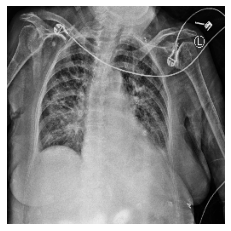

In [49]:
for images in inputImages.take(1):
    plt.imshow(images[0].numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

## segmentation

In [50]:
sys.path.append('../TOOLS/COVIDCXRChallenge-main')

In [51]:
import src.utils.util_segmentation as util_segmentation

In [52]:
import skimage.measure as measure

In [53]:
databasePath = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/newDB.csv')
databasePathIMAGES = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/')

In [54]:
COVID19 = pd.read_csv(databasePath)

In [55]:
paths = pd.DataFrame(COVID19[['FilePaths']])

In [56]:
imgDirs = []
for p in paths['FilePaths']:
    pt = str(str(databasePathIMAGES) + str(Path(p)))
    # print(Path(pt))
    imgDirs.append(pt)

# print(imgDirs)

In [57]:
n_test = len(inputImages)
inp_shape = 0
for images in inputImages.take(1):
    inp_shape = images[0].numpy().astype("uint8").shape
    

In [58]:
im_shape = (256,256)

In [59]:
print(n_test)
print(inp_shape)

1022
(256, 256, 1)


In [60]:
i = 0
# Bounding Boxes
dx_box = []
sx_box = []
all_box = []

In [95]:
# pathIn = databasePathIMAGES / Path('SEVERE')
# pathIn = Path('../../FUSION 2022/DATABASE_CNN/Img_Full_Size_From_DICOM_EQ')
# pathIn = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/MILD')
pathIn = Path('../CHEST-RAY-ONLY-LABELED-ICU-ALL-ORDERED/SEVERE')

# Img_Full_Size_From_DICOM_EQ

pathOut = Path('../CHEST-RAY-ONLY-LABELED-ICU-ALL-ORDERED/SEGMENTATION/SEVERE')
# pathOut = Path('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/SEGMENTATION/MILD')
# pathOut = Path('../../FUSION 2022/DATABASE_CNN/Img_Full_Size_From_DICOM_SEGMENTATION')

In [96]:
from skimage import morphology, transform

In [97]:
def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [98]:

Path(pathOut).mkdir(parents=True, exist_ok=True)

notsegmented = 0


for filename in tqdm(os.listdir(pathIn)):
    f = pathIn / filename
    fo = Path(pathOut) / filename

    
    # print(f)



    fullImg = np.asarray(load_img(f,color_mode="grayscale"))

    # print(fullImg.shape)
    
    img = np.asarray(load_img(f,target_size=(256,256),color_mode="grayscale"))

    imgNorm = (img - np.min(img)) / (np.max(img) - np.min(img))

    imgNorm = np.expand_dims(imgNorm, axis=2)
    imgNorm = np.expand_dims(imgNorm, axis=0)
    
    # print(imgNorm.shape)

    pred = segmentationModel.predict(imgNorm,verbose = 0)[..., 0].reshape(inp_shape[:2])

    ppr = pred > 0.05
    # print(pred.shape)
    pr = pred > 0.4

    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

    pr = transform.resize(pr,(fullImg.shape))
    # print(pr.shape)

    lbl = measure.label(pr)
    # print(lbl)
    props = measure.regionprops(lbl)
    # print(len(props))

    bbox = pred

    # plt.figure()
    # plt.imshow(pr, cmap='gray')
    # plt.axis("off")
    dx_box = []
    sx_box = []

    # # BOUNDING BOX SAVE
    # #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

    # if len(props) >= 2:
    #     box_1 = props[0].bbox
    #     box_2 = props[1].bbox

    #     if box_1[1] < box_2[1]:
    #         dx_box.append(list(box_1))
    #         sx_box.append(list(box_2))
    #     else:
    #         dx_box.append(list(box_2))
    #         sx_box.append(list(box_1))
    #     # get box for both lungs
    #     props = measure.regionprops(pr.astype("int64"))
    #     if len(props) == 1:
    #         dx_box.append([0, 0, lbl.shape[0], lbl.shape[1]])
    # else:
    #     # dx_box.append(None)
    #     # sx_box.append(None)
    #     dx_box.append([0, 0, lbl.shape[0], lbl.shape[1]])
    #     notsegmented = notsegmented +1

    # i += 1
    # if i == n_test:
    #     break
    
    # print(dx_box)
    # print(sx_box)

    # # maskedImg = np.zeros((fullImg.shape[1],fullImg.shape[0]))
    # maskedImg = np.zeros((fullImg.shape))
    # # maskedImg = np.zeros((fullImg.shape[0],fullImg.shape[1]))
    # # print(maskedImg.shape)

    # # plt.figure()
    # # plt.imshow(fullImg, cmap='gray')


    # if (len(dx_box)>0):
    #     # print(dx_box[0])
    #     x1, y1, x2, y2 = dx_box[0]
    #     maskedImg[x1:x2,y1:y2] = fullImg[x1:x2,y1:y2]

    # if (len(sx_box)>0):
    #     x1, y1, x2, y2 = sx_box[0]
    #     maskedImg[x1:x2,y1:y2] = fullImg[x1:x2,y1:y2]

    # # maskedImg = maskedImg > 0.5
    
    # # plt.figure()
    # # plt.imshow(maskedImg, cmap='gray')


    # # maskedImg = Image.fromarray((maskedImg)*255,'L')
    
    # # img = deleteWritings(str(f),kerasOcr_pipeline)
    # # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # cv2.imwrite(str(fo),maskedImg)

# # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


    # # SHAPE ONLY
    # #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


    ppr = remove_small_regions(ppr, 0.02 * np.prod(im_shape))

    ppr = transform.resize(ppr,(fullImg.shape))
    ppr = ppr<0.5
    maskedImg = fullImg
    if len(props) >= 2:
        #found something
        maskedImg[ppr] = 0

        # plt.figure()
        # plt.imshow(maskedImg, cmap='gray')
    
    else:
        #not found any
        # print('lol')
        notsegmented = notsegmented +1


    
    cv2.imwrite(str(fo),maskedImg)

# #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

print('number of not segmented images: '+str(notsegmented))


100%|██████████| 2631/2631 [17:15<00:00,  2.54it/s]

number of not segmented images: 2628


In [99]:
# for el in tqdm(inputImages):
#     for xx in inputImages.take(1):
#         xx = xx[0]
#         xxNorm = xx/255.0
#         print(xx.shape)

#         pred = segmentationModel.predict(np.expand_dims(xxNorm, axis=0))[..., 0].reshape(inp_shape[:2])

#         pred = pred > 0.5
#         pred = np.expand_dims(pred, axis=2)
#         pred = pred.astype(np.uint8)

#         inputImg = xx.numpy()

#         # print(pred.shape)
        
#         masked = cv2.bitwise_and(inputImg, inputImg, mask=pred)

#         plt.figure()
#         plt.imshow(masked, cmap='gray')
#         plt.axis("off")

        
#     break

In [100]:
# p = segmentationModel.predict(inputImages)

In [101]:
# p[0]

In [102]:
# plt.figure()
# plt.imshow(p[0], cmap='gray')
# plt.axis("off")

In [103]:
from PIL import Image

In [104]:
for pt, A in zip(os.listdir('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/EQUALIZED/A/MILD'),p):
    print(pt)
    print(A.shape)
    im = Image.fromarray(A)
    im.save('../CHEST-RAY-ONLY-LABELED-ICU-ONE-PER-PATIENT-OLDEST/LUNG-ONLY/MILD/' +pt)

0_A917122.png


AttributeError: 'str' object has no attribute 'shape'